# Part I - estimating missing log values

* **Part I  - estimating missing log values**
* Part II - testing ssGMM
* Part III - facies classification using ssGMM

**Author: Michael W. Dunham**

**Date: September 3, 2019**

This Jupyter notebook is Part I in a series that focuses on estimating the missing values in this dataset so it can be complete prior to any classification of the dataset. Two of the wells (ALEXANDER and KIMZEY) do not contain one of the features/variables, which is photoelectric effect (PE). We set up a regression algorithm, support vector regression (SVR), that uses all log information (except PE) to predict for PE. 

We split the training data (8 wells) into training and validation sets, and the learned SVR is evaluated on the validation set to get a sense for error. Then, we use the learned SVR model to predict the PE logs for the ALEXANDER and KIMZEY wells; we output these predictions and add them to the Excell file to fill in their missing values. This 'new' Excell file is used in the subsequent Jupyter notebooks in this series.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
import sys, sklearn, xgboost, joblib
print('This Jupyter-Notebook has been executed using the following packages/versions:')
print('Python:       ' + sys.version.split('\n')[0])
print('Pandas:       ' + pd.__version__)
print('Numpy:        ' + np.__version__)
print('Matplotlib:   ' + mpl.__version__)
print('Sklearn:      ' + sklearn.__version__)

This Jupyter-Notebook has been executed using the following packages/versions:
Python:       3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Pandas:       0.24.2
Numpy:        1.16.2
Matplotlib:   3.0.3
Sklearn:      0.20.3


# Loading the well log dataset
The 'facies_vectors.csv' file is the original data file provided by [Hall (2016)](https://doi.org/10.1190/tle35100906.1) on their github website (https://github.com/seg/2016-ml-contest). 

In [3]:
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'facies_vectors.csv'
all_data = pd.read_csv(filename)

Defining a color map so the facies are represented by a consistent color in the plots below.  We also create the abbreviated facies labels, and add those to the dataframe.

In [4]:
# Nonmarine facies: 1=sandstone, 2=coarse_siltstone, 3=fine_siltstone 
# Marine facies: 4=marine_silt_shale, 5=mudstone, 6=wackestone, 7=dolomite, 8=packstone, 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
all_data.loc[:,'FaciesLabels'] = all_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

You will notice below that there are 4149 total data points for each variable, EXCEPT photoelectric effect (PE). This suggests there are missing values for this variable

In [5]:
all_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [6]:
all_data['Well Name'] = all_data['Well Name'].astype('category')
all_data['Formation'] = all_data['Formation'].astype('category')
print("The names of all 10 wells:")
print(all_data['Well Name'].unique())

The names of all 10 wells:
[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]


## Isolating wells with and without PE
* As it turns out, there are two entire wells (KIMZEY and ALEXANDER) that do not have PE and these two wells account for all the missing PE values
* We are going to set up a regression problem to estimate the PE for these two wells. This is a regression and not a classification problem because are trying to predict *real values*
* The training data will consist of all the data for the remaining eight wells and the testing data will consist of the KIMZEY and ALEXANDER wells

In [7]:
## Saving the two wells with no PE to their own dataframe
blind1 = all_data[(all_data['Well Name'] == 'ALEXANDER D')]
blind2 = all_data[(all_data['Well Name'] == 'KIMZEY A')]

## The remaining eight wells will serve as the training data
all_data = all_data[all_data['Well Name'] != 'ALEXANDER D']
all_data = all_data[all_data['Well Name'] != 'KIMZEY A']

In [8]:
## This now shows that 'all_data' consists of the eight wells
print(all_data['Well Name'].unique())
all_data.describe()

[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,3244.000000,3232.000000,3244.000000,3244.000000
mean,4.438964,2876.417078,66.023039,0.643251,3.570762,13.470186,3.725014,1.500308,0.520370
std,2.515013,131.299298,30.872247,0.242801,5.228623,7.688998,0.896152,0.500077,0.286642
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.875000,46.757500,0.491000,1.191500,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2894.500000,65.648000,0.624796,3.500000,12.139000,3.551500,2.000000,0.526000
75%,6.000000,2980.500000,79.589500,0.813250,6.500000,16.415250,4.300000,2.000000,0.767000
max,9.000000,3131.500000,361.150000,1.505000,18.600000,84.400000,8.094000,2.000000,1.000000


In [9]:
## The Recruit F9 (synthetic) well still has a few NaNs in the PE collumn, so we simply remove those here
all_data = all_data.dropna(axis = 0)

## Establishing the training features and targets
* The features are: GR, ILD_log10, DeltaPHI, PHIND, NM_M, Facies
* The targets are: PE (numeric)

In [10]:
training_PE = all_data['PE'].values
training_features = all_data.drop(['Formation', 'Well Name', 'Depth','PE','FaciesLabels'], axis=1)
training_features.describe()

,Facies,GR,ILD_log10,DeltaPHI,PHIND,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,66.135769,0.642719,3.559642,13.483213,1.498453,0.520287
std,2.504243,30.854826,0.241845,5.228948,7.698980,0.500075,0.286792
min,1.000000,13.250000,-0.025949,-21.832000,0.550000,1.000000,0.010000
25%,2.000000,46.918750,0.492750,1.163750,8.346750,1.000000,0.273000
50%,4.000000,65.721500,0.624437,3.500000,12.150000,1.000000,0.526000
75%,6.000000,79.626250,0.812735,6.432500,16.453750,2.000000,0.767250
max,9.000000,361.150000,1.480000,18.600000,84.400000,2.000000,1.000000


## Standardizing the data
Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance). The `StandardScalar` class standardizes based on the mean and standard deviation of each variable, which can be fit to the training set, but can also be later used to standardize any testing data.

In [11]:
scaler = StandardScaler().fit(training_features)
scaled_features = scaler.transform(training_features)

C:\Users\mwdunham\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mwdunham\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


# Splitting the training data into training and validation sets

We do not know the true PE values for the KIMZEY and ALEXANDER wells, so we cannot determine the performance of any algorithm on those predictions. What is typically done is the training data is split into training and validation sets; the algorithm is trained on the training data subset, and then the performance can of the algorithm can actually be evaluated on the *validation* subset because the true targets are known. 

Here we use an 80/20 split where 20% of the training data is used for validation purposes and it not used for training in any way. 

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, training_PE, test_size=0.2, random_state=42)

## Training the SVR

We now use the training dataset to train a regression algorithm to predict for PE.  We use a particular regression algorithm known as a [support vector regressor (SVR)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).  

The SVR implementation in [scikit-learn](https://scikit-learn.org/stable/index.html) requires setting a few hyper-parameters such as 'C' and 'epsilon'. We use a 5-fold grid search cross-validation (CV) approach on the training data to determine values for these two parameters.

The error reported is the error on the 20% validation set that was not involved in training. This helps give an indication of the error we might expect on the PE predictions for the KIMZEY and ALEXANDER wells

In [13]:
num = 10
SVR_parameters = [{'C': np.logspace(0, 2, num, endpoint = True), 'epsilon': np.logspace(-2, 0, num, endpoint = True)}]
print("Tuning SVR hyper-parameters for accuracy score with grid search")
svr = GridSearchCV(SVR(kernel='rbf', gamma = 'auto', tol=0.001), SVR_parameters, scoring='neg_mean_squared_error', n_jobs = -1, cv = 5)
svr.fit(X_train, y_train)
print("Best SVR parameters set found on development set:")
print(svr.best_params_)

print("")
print("Grid scores on development set:")
means = svr.cv_results_['mean_test_score']
stds = svr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

y_pred_svr = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred_svr)
print("")
print("Mean squared error of SVR on validation set: ", + svr_error)

Tuning SVR hyper-parameters for accuracy score with grid search
Best SVR parameters set found on development set:
{'C': 21.544346900318832, 'epsilon': 0.046415888336127774}

Grid scores on development set:
-0.208 (+/-0.028) for {'C': 1.0, 'epsilon': 0.01}
-0.208 (+/-0.027) for {'C': 1.0, 'epsilon': 0.016681005372000592}
-0.207 (+/-0.027) for {'C': 1.0, 'epsilon': 0.027825594022071243}
-0.207 (+/-0.027) for {'C': 1.0, 'epsilon': 0.046415888336127774}
-0.207 (+/-0.027) for {'C': 1.0, 'epsilon': 0.0774263682681127}
-0.207 (+/-0.027) for {'C': 1.0, 'epsilon': 0.1291549665014884}
-0.208 (+/-0.027) for {'C': 1.0, 'epsilon': 0.21544346900318834}
-0.214 (+/-0.026) for {'C': 1.0, 'epsilon': 0.3593813663804626}
-0.236 (+/-0.023) for {'C': 1.0, 'epsilon': 0.5994842503189409}
-0.292 (+/-0.027) for {'C': 1.0, 'epsilon': 1.0}
-0.202 (+/-0.026) for {'C': 1.6681005372000588, 'epsilon': 0.01}
-0.202 (+/-0.025) for {'C': 1.6681005372000588, 'epsilon': 0.016681005372000592}
-0.201 (+/-0.024) for {'C': 1.

## Compare predicted vs. known PE values in one well
* Here we select one of the wells, SHANKLE, and compare the predicted and the known PE values
* The raw predictions are sometimes a little noisy, so we apply a Gaussian filter to reduce the amount of spikes

In [14]:
from scipy.ndimage.filters import gaussian_filter1d

# Need the logs and prediction for just ONE well
ONEWELL_data = all_data[all_data['Well Name'] == 'SHANKLE']
ONEWELL_true_PE = ONEWELL_data['PE'].values

ONEWELL_data_X = ONEWELL_data.drop(['Formation', 'Well Name', 'Depth','PE','FaciesLabels'], axis=1)
ONEWELL_data_X_scaled = scaler.transform(ONEWELL_data_X)
ONEWELL_data_X_scaled

ONEWELL_pred_PE = svr.predict(ONEWELL_data_X_scaled)
ONEWELL_pred_PE = gaussian_filter1d(ONEWELL_pred_PE, sigma = 1, order = 0) #This is filtering the predictions slightly to reduce spikes
ONEWELL_data['PE Prediction'] = ONEWELL_pred_PE

C:\Users\mwdunham\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


This is a well viewer that is modified from the Jupyter-notebook code (Facies_classification.ipynb) provided by [Hall (2016)](https://doi.org/10.1190/tle35100906.1) on their [github repository](https://github.com/seg/2016-ml-contest) to analyze the true and predicted PE for a given well.

In [15]:
def log_plot_compare_PE(logs, PE_prediction, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    ax[4].plot(logs[PE_prediction].values, logs.Depth, '-', color='green')

    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_facies,vmin=1,vmax=9)
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_ylabel("Depth (m)", fontsize = 20)
    ax[0].set_xlabel("GR", fontsize = 16)
    ax[0].set_xlim(logs.GR.min(),100)
    ax[1].set_xlabel("ILD_log10", fontsize = 16)
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI", fontsize = 16)
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND", fontsize = 16)
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE", fontsize = 16)
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies', fontsize = 16)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=20,y=0.91)

* The black PE curve is the true PE, and the green PE curve is the predicted PE from the SVR
* The predicted PE curve reproduces the true PE quite well.

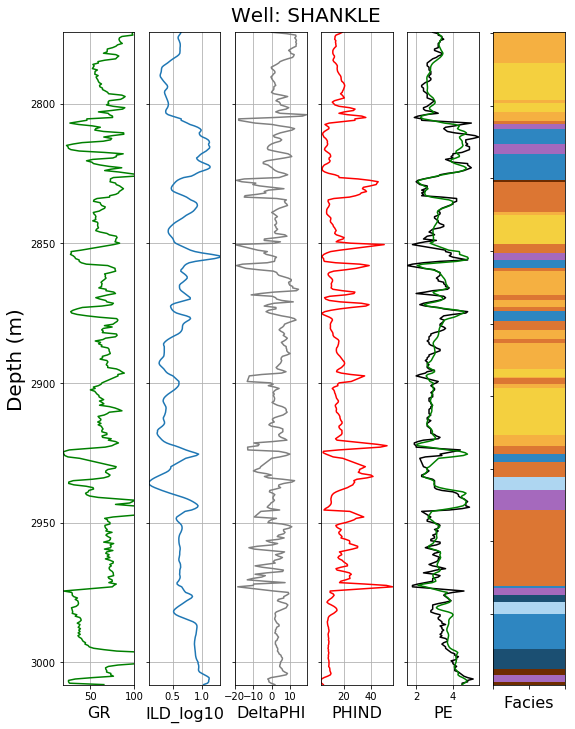

In [16]:
log_plot_compare_PE(ONEWELL_data, 'PE Prediction', facies_colors)

# Predicting PE for the KIMZEY and ALEXANDER wells

blind1 is the dataframe containing all the features (except PE) for the ALEXANDER well

In [17]:
blind1

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
471,3,A1 SH,ALEXANDER D,2887.5,88.71,0.612,6.7,10.605,NaN,1,1.000,FSiS
472,3,A1 SH,ALEXANDER D,2888.0,92.71,0.583,11.0,12.515,NaN,1,0.974,FSiS
473,3,A1 SH,ALEXANDER D,2888.5,94.54,0.579,12.0,13.410,NaN,1,0.949,FSiS
474,3,A1 SH,ALEXANDER D,2889.0,95.31,0.579,11.5,13.750,NaN,1,0.923,FSiS
475,3,A1 SH,ALEXANDER D,2889.5,93.79,0.572,10.3,13.405,NaN,1,0.897,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
932,8,C LM,ALEXANDER D,3119.0,68.34,0.910,-1.8,8.065,NaN,2,0.043,PS
933,8,C LM,ALEXANDER D,3119.5,67.87,0.926,1.8,8.175,NaN,2,0.034,PS
934,8,C LM,ALEXANDER D,3120.0,66.00,0.928,6.3,8.540,NaN,2,0.026,PS
935,8,C LM,ALEXANDER D,3120.5,67.39,0.898,9.6,9.755,NaN,2,0.017,PS


* The features for ALEXANDER are isolated and the SVR is used to predict its PE values
* The predicted PE is also filtered again slightly

In [18]:
blind1_X = blind1.drop(['Formation', 'Well Name','Depth','PE','FaciesLabels'], axis=1)
blind1_X_scaled = scaler.transform(blind1_X)
blind1_X_scaled

blind1_pred_PE = svr.predict(blind1_X_scaled)
blind1_pred_PE = gaussian_filter1d(blind1_pred_PE, sigma = 1, order = 0) #This is filtering the predictions slightly

blind1 = blind1.drop(['PE'], axis=1)
blind1['PE'] = blind1_pred_PE

C:\Users\mwdunham\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


This is a well viewer that is modified from the Jupyter-notebook code (Facies_classification.ipynb) provided by [Hall (2016)](https://doi.org/10.1190/tle35100906.1) on their [github repository](https://github.com/seg/2016-ml-contest) to view the PE prediction for the two wells that contain missing PE values.

In [19]:
def log_plot_blind_PE(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')

    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_facies,vmin=1,vmax=9)
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_ylabel("Depth (m)", fontsize = 20)
    ax[0].set_xlabel("GR", fontsize = 16)
    ax[0].set_xlim(logs.GR.min(),100)
    ax[1].set_xlabel("ILD_log10", fontsize = 16)
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI", fontsize = 16)
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND", fontsize = 16)
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE", fontsize = 16)
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies', fontsize = 16)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=20,y=0.91)

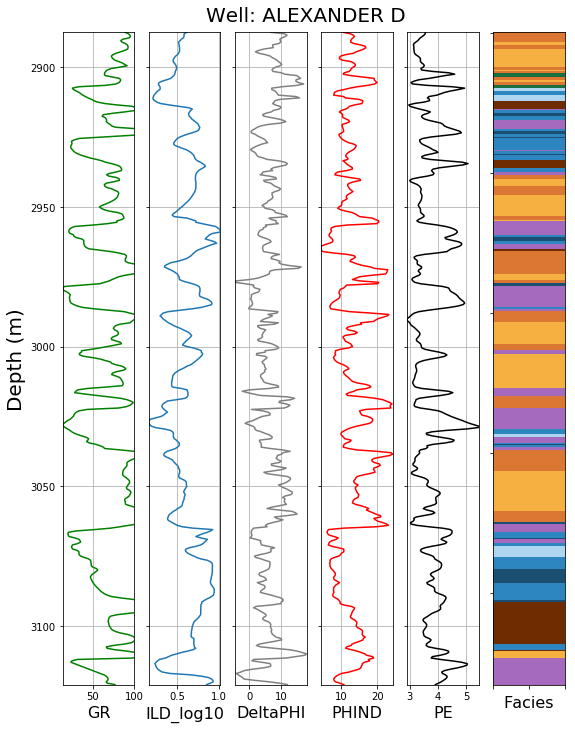

In [20]:
log_plot_blind_PE(blind1, facies_colors)

blind2 is the dataframe containing all the features (except PE) for the KIMZEY well

In [21]:
blind2

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
1847,1,A1 SH,KIMZEY A,2918.5,73.816,0.769,5.226,11.3480,NaN,1,1.000,SS
1848,1,A1 SH,KIMZEY A,2919.0,75.118,0.627,8.198,13.1640,NaN,1,0.978,SS
1849,1,A1 SH,KIMZEY A,2919.5,72.434,0.535,10.867,15.0755,NaN,1,0.956,SS
1850,2,A1 SH,KIMZEY A,2920.0,66.161,0.568,4.566,16.9050,NaN,1,0.933,CSiS
1851,2,A1 SH,KIMZEY A,2920.5,63.104,0.650,2.083,15.8835,NaN,1,0.911,CSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
2281,4,C LM,KIMZEY A,3136.0,86.023,0.688,10.949,11.7335,NaN,2,0.405,SiSh
2282,6,C LM,KIMZEY A,3136.5,101.037,0.732,10.179,12.0085,NaN,2,0.393,WS
2283,6,C LM,KIMZEY A,3137.0,153.374,0.748,8.198,13.4390,NaN,2,0.381,WS
2284,6,C LM,KIMZEY A,3137.5,144.117,0.672,9.188,13.4390,NaN,2,0.369,WS


In [22]:
blind2_X = blind2.drop(['Formation', 'Well Name','Depth','PE','FaciesLabels'], axis=1)
blind2_X_scaled = scaler.transform(blind2_X)
blind2_X_scaled

blind2_pred_PE = svr.predict(blind2_X_scaled)
blind2_pred_PE = gaussian_filter1d(blind2_pred_PE, sigma = 1, order = 0) #This is filtering the predictions slightly

blind2 = blind2.drop(['PE'], axis=1)
blind2['PE'] = blind2_pred_PE

C:\Users\mwdunham\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


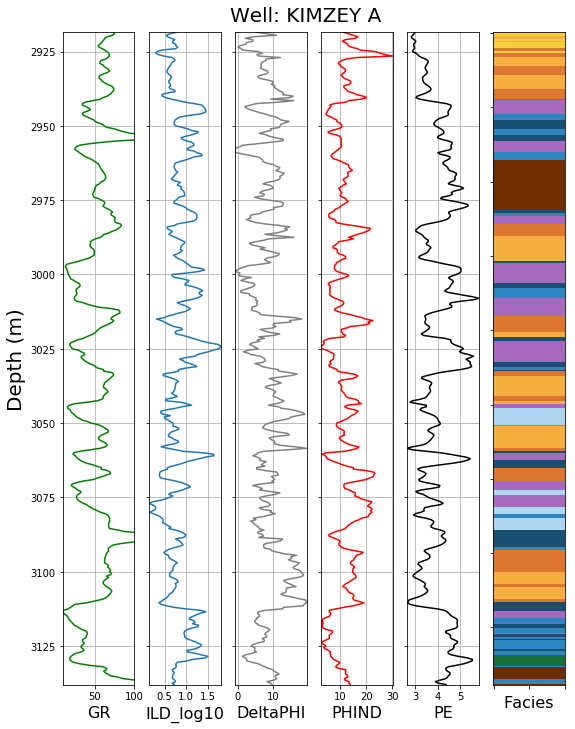

In [23]:
log_plot_blind_PE(blind2, facies_colors)

## Outputting predictions to files
* The predictions for KIMZEY and ALEXANDER appear reasonable.
* As a result, we export the PE predictions for ALEXANDER and KIMZEY and simply add them (manually) to the 'facies_vectors.csv' file. We rename this file to 'facies_vectors_complete.csv' to make the distinction. We load this file below and show that now the dataset contains complete values for all 4137 data points. 

In [24]:
blind1['PE'].to_csv('ALEXANDER_D_well_PE_log_values.csv')

C:\Users\mwdunham\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [25]:
blind2['PE'].to_csv('KIMZEY_A_well_PE_log_values.csv')

C:\Users\mwdunham\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [26]:
filename = 'facies_vectors_complete.csv'
complete_data = pd.read_csv(filename)
complete_data = complete_data.dropna(axis=0)
complete_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000
mean,4.490210,2906.492869,65.018896,0.659198,4.396208,13.210462,3.758416,1.517283,0.521791
std,2.466009,133.176827,30.290153,0.252039,5.276518,7.139950,0.847002,0.499762,0.286762
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.940000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000
50%,4.000000,2932.500000,65.107000,0.639000,4.300000,12.036000,3.600000,2.000000,0.527000
75%,6.000000,3006.500000,79.470000,0.822000,7.500000,16.066000,4.317000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000
